# Joe Stanley
### Stanley Solutions
Testing and modeling environment for water heating/cooling model.

References:
- http://jwilson.coe.uga.edu/EMAT6680Fa07/Lowe/Assignment%2012/CoolingWater.html
- https://sciencing.com/calculate-time-heat-water-8028611.html

In [100]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import convert_temperature as conv_temp

# Define System Parameters
k = 0.01457 # From Web, not Terribly Accurate
g = 10 # Gallons in Container
P = 500

###### ALL TIME IS MEASURED IN MINUTES #####

In [101]:
# Define Modeling Functions
def gallons(liters):
    gal = liters/3.78541
    return(gal)
def liters(gallons):
    lit = gallons*3.78541
    return(lit)

def newtoncooling(t,temp0,tempenv):
    temp = tempenv + (temp0-tempenv)*np.exp(-k*t)
    return(temp)

def heating(t,Power,temp0):
    temp0 = conv_temp(temp0,'f','c')
    Pkw = Power/1000
    temp = temp0 + (60*Pkw*t)/(4.2*liters(g))
    print(temp0,Pkw,liters(g))
    temp = conv_temp(temp,'c','f')
    return(temp)

def combined(t,Power,temp0,tempenv):
    cool = newtoncooling(t,temp0,tempenv)
    heat = heating(t,Power,temp0) - temp0
    return(cool+heat)

1.6666666666666856 0.5 37.8541
1.6666666666666856 0.5 37.8541


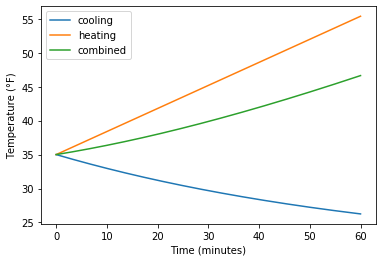

In [102]:
# Model SIMPLE Systems, Nothing Advanced
t_hr = np.linspace(0,60,600)
t0 = 35
te = 20
cool = newtoncooling(t_hr,t0,te)
heat = heating(t_hr,P,t0)
sys = combined(t_hr,P,t0,te)
plt.plot(t_hr, cool, label='cooling')
plt.plot(t_hr, heat, label='heating')
plt.plot(t_hr, sys, label='combined')
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.show()

## First model was not accurate...
It did not appropriately account for time.

In [103]:
# Define Avista Billing Rates
ratelt600 = 0.08458 # $/kwh
rategt600 = 0.09521 # $/kwh

In [104]:
# Define New Temperature Model
class troughmodel():
    def __init__(self,temp0,Pwatts,volume,k,threshold=45):
        # Define Simple Heater
        self._t0 = temp0
        self._Pkw = Pwatts/1000
        self._k = k
        self._temp = [temp0]
        self._heater_en = [False]
        self._threshold = threshold
        self._volume = volume
        self._index = 0
    
    def update(self,ambient,k=None):
        if k != None:
            self._k = k
        temp = self._temp[self._index]
        # Determine Temperature Change from Both Heating and Cooling
        newTemp = ambient + (temp-ambient)*np.exp(-self._k)
        heatC = (temp-32)*5/9 + (60*self._Pkw)/(4.2*liters(self._volume))
        heat = (heatC*9/5) + 32
        # Convert Heating Effect back to Fahrenheit
        dt_heat = heat-temp
        # Determine whether Heater should be Applied
        if temp >= self._threshold:
            self._heater_en.append(False) # Don't Heat
        else:
            self._heater_en.append(True) # Apply Heater
            newTemp += dt_heat
        # Increment Index and Return New Temperature
        self._index += 1
        self._temp.append(newTemp)
        return(newTemp)
    
    def get_temp(self):
        return(self._temp)
    
    def get_heater_state(self):
        return(self._heater_en)
    
    def shrink_lists(self):
        self._temp = self._temp[-2:]
        self._heater_en = self._heater_en[-2:]

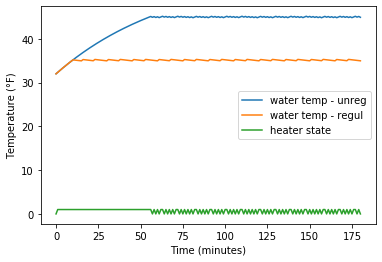

kWh Consumed (unregulated): 1.0333333333333334
kWh Consumed (regulated): 0.26666666666666666
Improvement: 74.19354838709678 %


In [111]:
# Demonstrate Model in Simple System
t0 = 32

model = troughmodel(t0,P,g,k,threshold=45)
mod_1 = troughmodel(t0,P,g,k,threshold=35)

# Process 180 minutes
minutes = 180
for _ in range(minutes):
    model.update(t0)
    mod_1.update(t0)

# Display Results
plt.plot(model.get_temp(),label='water temp - unreg')
plt.plot(mod_1.get_temp(),label='water temp - regul')
plt.plot(model.get_heater_state(),label='heater state')
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.show()

rate = sum(model.get_heater_state())/60
rate1 = sum(mod_1.get_heater_state())/60
consump = (P/1000) * rate
consump1 = (P/1000) * rate1
print("kWh Consumed (unregulated):",consump)
print("kWh Consumed (regulated):",consump1)
print("Improvement:",(consump-consump1)/consump*100,"%")

In [86]:
heating(1,500,28)

216000